In [91]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import math
%matplotlib inline

In [92]:
actual_file = r'\Cellulose110_8000Water.txt'
item_path = r'D:\all_programming\wetting-analysis\DataFiles' + actual_file

In [93]:
with open(item_path, 'r') as file:
    x_vals = {}
    y_vals = {}
    
    for row in file:
        if row.startswith('Frame: '):
            row = row.strip()
            junk, current_frame = row.split(': ')
            current_frame = int(current_frame) 
            x_vals[current_frame] = []
            y_vals[current_frame] = []

        elif row.startswith('{'):
            row = row.strip()
            row = row.replace(', ', 'ß')
            row = row.replace('} {', 'ß')
            row = row.replace('{', '')
            row = row.replace('}', '')
            broken_row = row.split('ß')

            for i in range(len(broken_row)):
                if i % 2 == 0:
                    x_vals[current_frame].append(float(broken_row[i]))
                elif i % 2 == 1:
                    y_vals[current_frame].append(float(broken_row[i]))

            x_vals_polished = {}
            for frame in x_vals.keys():
                min_x = min(x_vals[frame])
                x_vals_polished[frame] = []

                for item in x_vals[frame]:
                    x_vals_polished[frame].append(item + abs(min_x))

            x_vals = x_vals_polished

In [94]:
# Define the objective function
def objective(params, X, Y):
    a, b, y_0, C, x_0 = params
    summation = np.sum(np.abs((1/a**2)*X**2 - 2*x_0/a**2*X + (1/b**2)*Y**2 - 2*y_0/b**2*Y - C))
    return summation


In [95]:
# Define the implicit equation function
def implicit_eq(X, Y, a, b, y_0, C, x_0):
    return (X**2 / a**2) - (2 * x_0 * X / a**2) + (Y**2 / b**2) - (2 * y_0 * Y / b**2) - C

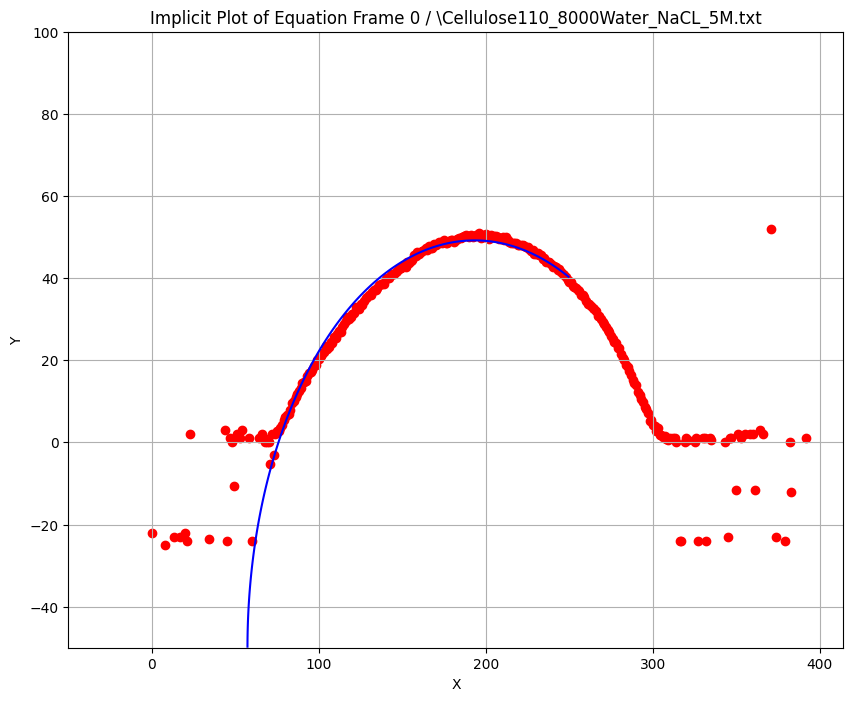

Optimal parameters: a=100.0, b=72.89903163323244, y_0=-50.0, C=-2.3554583376469296, x_0=193.2978028105888
Angle: 51.71666485314589°


In [96]:
frame_list = []
angle_list = []
x_0_list = []
ellipse_fit_error = 0

for frame in range(len(x_vals.keys())):
    
    X_data = np.array(x_vals[frame])  # X values
    Y_data = np.array(y_vals[frame])  # Y values
    
    x_0 = max(X_data) / 2  # Generally true statement 
    x_0_list.append(x_0)
    x_0_pm = 5

    # Initial guess for the parameters [a, b, y_0, C, x_0]
    initial_guess = [0.4, 0.5, -11.1, 10, x_0]

    # Define bounds for the parameters: (a, b, y_0, C, x_0)
    a_B = (0.1, 100)
    b_B = (0.1, 100)
    y_0_B = (-50, -20)
    C_B = (-100, 100)
    x_0_B = (x_0 - x_0_pm, x_0 + x_0_pm)
    
    bounds = [a_B, b_B, y_0_B, C_B, x_0_B] 

    # Perform the optimization
    result = minimize(objective, initial_guess, args=(X_data, Y_data), method='L-BFGS-B', bounds=bounds)

    # Extract the optimal parameters
    a_opt, b_opt, y_0_opt, C_opt, x_0_opt = result.x

    # Create a grid of points
    x = np.linspace(-50, 250, 400)
    y = np.linspace(-50, 100, 400)
    X, Y = np.meshgrid(x, y)
    Z = implicit_eq(X, Y, a_opt, b_opt, y_0_opt, C_opt, x_0_opt)

    # Plot the contour where Z = 0
    plt.figure(figsize=(10, 8))
    contour = plt.contour(X, Y, Z, levels=[0], colors='blue')
    plt.title(f'Implicit Plot of Equation Frame {frame} / {actual_file}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.scatter(X_data, Y_data, color='red')  # Scatter plot of your data points

    subdirectory = r'C:\Users\jeffs\Downloads\SZvsWorkspaceUpper\SZvsWorkspace\Research\Project2WettingAngle\ProgramOutputs\fitting_methods'
    plot_path = os.path.join(subdirectory, f'best_fit_ellipse{frame}.png')
    #plt.savefig(plot_path)

    plt.show()

    for i in range(len(x_vals[frame])):
        ellipse_fit_error += np.abs((1/(a_opt**2))*X_data[i]**2 - (2*x_0_opt/(a_opt**2))*X_data[i] + (1/(b_opt**2))*Y_data[i]**2 - (2*y_0_opt)/(b_opt**2)*Y_data[i] - C_opt)

    # Angle calculation
    x_a = x_0_opt + math.sqrt(x_0**2 + C_opt * a_opt**2)
    dydx_x_a = b_opt**2*(x_0-x_a)/(a_opt**2*(-y_0_opt))
    theta = abs(math.atan(dydx_x_a)) * 180 / math.pi

    # Creating x & y datas
    frame_list.append(frame)
    angle_list.append(theta)

    print(f"Optimal parameters: a={a_opt}, b={b_opt}, y_0={y_0_opt}, C={C_opt}, x_0={x_0_opt}")
    print(f'Angle: {theta}°')

In [97]:
junk, useful = item_path.split('DataFiles')
useful = useful.replace('\\', '')

In [98]:
average_theta = sum(angle_list) / len(angle_list)
print(f'File Name: {useful}')
print(f'Average CA: {round(average_theta,2)}°')

File Name: Cellulose110_8000Water_NaCL_5M.txt
Average CA: 51.72°
